In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) 
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1

W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 # shrunk down
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [54]:
torch.randn(1000).std()

tensor(0.9892)

In [56]:
(5/3) / ((10*3)**0.5) # larger than 0.1

0.3042903097250923

tensor(-0.0004) tensor(0.9998)
tensor(0.0002) tensor(0.9863)


(array([3.90587367e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.90587367e-05, 3.90587367e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.90587367e-05, 0.00000000e+00,
        3.90587367e-05, 3.90587367e-05, 0.00000000e+00, 3.90587367e-05,
        1.56234947e-04, 1.56234947e-04, 3.90587367e-05, 2.73411157e-04,
        3.12469893e-04, 2.73411157e-04, 4.29646103e-04, 5.46822313e-04,
        7.81174733e-04, 9.37409680e-04, 1.56234947e-03, 1.99199557e-03,
        2.65599409e-03, 3.94493240e-03, 5.07763577e-03, 6.91339639e-03,
        8.24139343e-03, 9.53033174e-03, 1.32799705e-02, 1.84747824e-02,
        2.37867706e-02, 3.00361685e-02, 3.82775619e-02, 4.66361316e-02,
        6.35876233e-02, 7.63598302e-02, 9.56157873e-02, 1.11864222e-01,
        1.40103688e-01, 1.68772801e-01, 1.94434391e-01, 2.33727480e-01,
        2.71458220e-01, 3.07978139e-01, 3.48169579e-01, 3.78401041e-01,
        4.06562390e-01, 4.31638099e-01, 4.38434319e-01, 4.344503

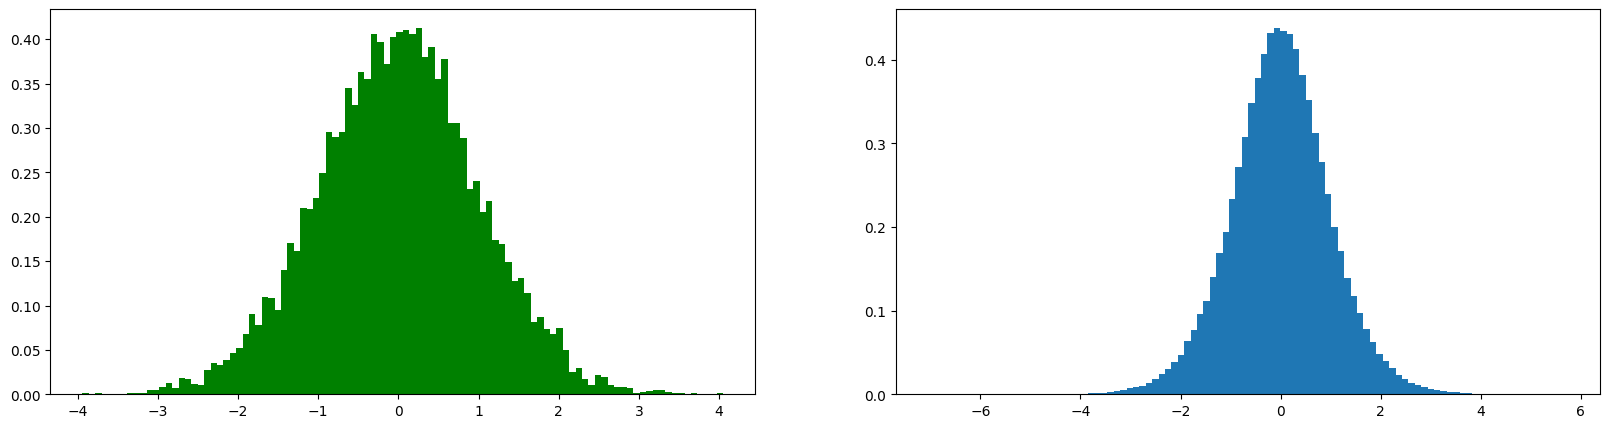

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 # we want to preserve the variance, bringing kaiming initialization
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std()) # std expanded

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), bins=100, density=True, color='green')
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), bins=100, density=True)

It's easier for a deeper nnet with batchnorm, rather than supressing the variance

In [62]:
hpreact.shape
hpreact.mean(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 # + b1 since it will be subtracted during BN phase # hidden layer pre-activation
  bnmeani = hpreact.mean(dim=0, keepdim=True)
  bnstdi = hpreact.std(dim=0, keepdim=True)
  # batch norm introduces small jitter from other data points in the same batch (which helps to avoid overfitting)
  hpreact = bngain * (hpreact - bnmeani) / (bnstdi + 1e-5) + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break
  

      0/ 200000: 3.7900
  10000/ 200000: 2.1610
  20000/ 200000: 2.3371
  30000/ 200000: 2.4170
  40000/ 200000: 1.9331
  50000/ 200000: 2.3079
  60000/ 200000: 2.4516
  70000/ 200000: 2.0803
  80000/ 200000: 2.2000
  90000/ 200000: 2.2031
 100000/ 200000: 1.9266
 110000/ 200000: 2.3861
 120000/ 200000: 1.9436
 130000/ 200000: 2.3739
 140000/ 200000: 2.3204
 150000/ 200000: 2.1260
 160000/ 200000: 1.9620
 170000/ 200000: 1.7552
 180000/ 200000: 2.1488
 190000/ 200000: 1.8570


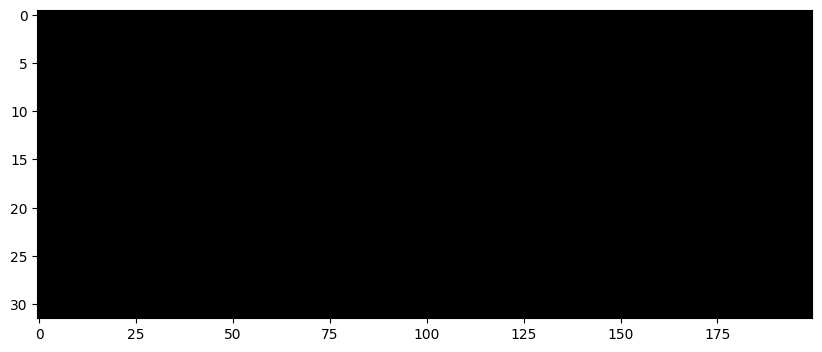

In [38]:
plt.figure(figsize=(10, 4))
plt.imshow(h.abs() > 0.99, aspect='auto', cmap='gray', interpolation='nearest')
# if one column is all zeros, then the corresponding neruon will never be activated

(array([2141.,  135.,   90.,   60.,   83.,   75.,   36.,   42.,   28.,
          22.,   40.,   36.,   13.,   26.,   20.,   35.,   14.,   20.,
          21.,   31.,   10.,   25.,   18.,   14.,   17.,   20.,   26.,
          19.,   25.,   21.,   28.,   31.,   23.,   18.,   37.,   13.,
          15.,   33.,   26.,   30.,   34.,   31.,   24.,   44.,   43.,
          62.,   70.,   71.,  120., 2484.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

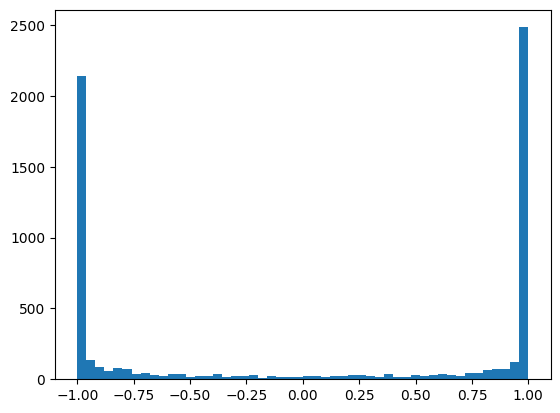

In [29]:
plt.hist(h.view(-1).tolist(), bins=50)

(array([  1.,   0.,   0.,   0.,   6.,   3.,   3.,  14.,  16.,  12.,  19.,
         49.,  76.,  70.,  95., 122., 159., 198., 232., 256., 269., 289.,
        338., 467., 467., 445., 367., 364., 309., 287., 297., 251., 187.,
        160., 121., 119.,  90.,  78.,  52.,  34.,  24.,  23.,  12.,   9.,
          6.,   3.,   0.,   0.,   0.,   1.]),
 array([-23.34049034, -22.39915062, -21.4578109 , -20.51647118,
        -19.57513145, -18.63379173, -17.69245201, -16.75111229,
        -15.80977257, -14.86843285, -13.92709312, -12.9857534 ,
        -12.04441368, -11.10307396, -10.16173424,  -9.22039452,
         -8.27905479,  -7.33771507,  -6.39637535,  -5.45503563,
         -4.51369591,  -3.57235619,  -2.63101646,  -1.68967674,
         -0.74833702,   0.1930027 ,   1.13434242,   2.07568214,
          3.01702187,   3.95836159,   4.89970131,   5.84104103,
          6.78238075,   7.72372047,   8.6650602 ,   9.60639992,
         10.54773964,  11.48907936,  12.43041908,  13.3717588 ,
         14.313098

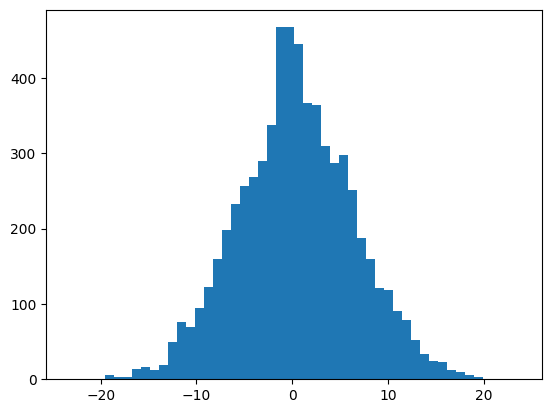

In [30]:
plt.hist(hpreact.view(-1).tolist(), bins=50)

In [21]:
logits[0]

tensor([-7.8045,  1.3661,  0.2092, -1.0037,  1.9308,  0.5186, -1.8585, -0.6509,
        -0.5420,  0.9686, -0.9348, -0.3093,  3.2968,  2.9501,  1.5198, -0.3674,
        -0.7595, -9.6586,  2.2881,  2.3076,  0.5807, -1.0444,  2.5553, -0.9842,
        -1.4227,  0.4744,  1.1828], grad_fn=<SelectBackward0>)

In [18]:
# logits = torch.tensor([1.0, 1.0, 7.0, 1.0,])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[1].log()
probs, loss

(tensor([1.0000e+00, 1.2735e-10, 1.1086e-10, 2.6414e-07]), tensor(22.7841))

In [10]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

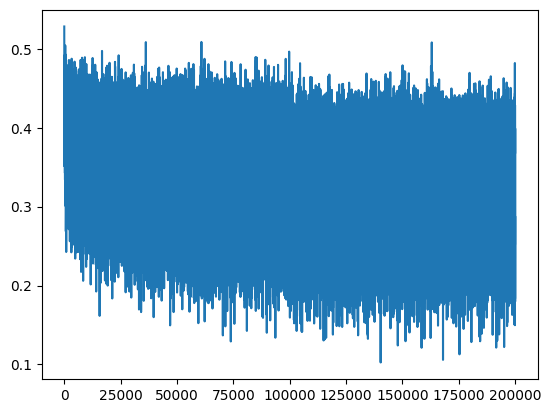

In [59]:
plt.plot(lossi)

In [72]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    emb = C[Xtr] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    bnmean = hpreact.mean(dim=0, keepdim=True) # (1, n_hidden)
    bnstd = hpreact.std(dim=0, keepdim=True) # (1, n_hidden)

# we don't want to do this every time after training
bnmean

tensor([[ 3.2857e-01,  6.8673e-01, -7.3731e-01,  1.2091e+00,  7.4193e-01,
          9.8967e-01,  3.7628e-01,  1.5186e-01, -3.6779e-01,  3.4692e-01,
         -6.4902e-01, -1.0688e+00, -4.1296e-01,  7.0475e-01, -1.7473e-01,
         -5.9648e-01,  4.1092e-01, -2.4650e+00, -4.7359e-01,  7.8785e-01,
         -5.2508e-01, -1.0489e+00,  5.7528e-02, -3.8538e-01,  5.2178e-01,
          4.5196e-01,  7.1194e-01,  4.6900e-01,  1.1874e-02,  8.5742e-01,
         -2.4032e-01, -1.0166e-01, -5.0770e-01,  3.5178e-01, -6.0482e-01,
         -3.2011e-01, -5.7491e-01, -4.6865e-01, -9.0634e-01,  4.9409e-01,
         -1.0164e+00,  4.6162e-02, -2.5429e-01, -8.7855e-01,  3.8650e-01,
         -4.9413e-01,  6.7401e-01, -3.2694e-02,  1.6203e+00,  2.8659e-01,
          7.8139e-01,  3.7762e-01,  1.0755e+00,  5.9739e-01,  4.1446e-02,
         -1.0631e+00,  8.9766e-01,  6.8600e-01,  1.1770e+00,  3.9893e-01,
         -1.5859e-01, -2.2744e-02,  2.8199e-01,  4.9013e-01, -1.0554e-01,
          1.2989e+00,  3.7264e-02, -8.

In [ ]:
bnmean_running # great estimate of mean

tensor([[ 3.1900e-01,  6.9609e-01, -7.4863e-01,  1.2112e+00,  7.4454e-01,
          9.8294e-01,  3.8647e-01,  1.5018e-01, -3.6324e-01,  3.5034e-01,
         -6.6909e-01, -1.0675e+00, -4.0727e-01,  7.0034e-01, -1.6316e-01,
         -5.8217e-01,  4.0822e-01, -2.4640e+00, -4.8705e-01,  7.7676e-01,
         -5.2912e-01, -1.0353e+00,  6.6844e-02, -3.8334e-01,  5.2182e-01,
          4.6401e-01,  7.1435e-01,  4.6214e-01,  6.6210e-03,  8.5694e-01,
         -2.4894e-01, -9.3733e-02, -5.1173e-01,  3.5455e-01, -6.0446e-01,
         -3.3001e-01, -5.7425e-01, -4.7109e-01, -8.9227e-01,  4.9571e-01,
         -1.0144e+00,  3.5227e-02, -2.4815e-01, -8.8048e-01,  3.9702e-01,
         -4.9589e-01,  6.8194e-01, -4.2498e-02,  1.6135e+00,  2.7732e-01,
          7.8752e-01,  3.8214e-01,  1.0576e+00,  5.9915e-01,  5.2496e-02,
         -1.0599e+00,  8.9333e-01,  6.8323e-01,  1.1770e+00,  3.9059e-01,
         -1.5857e-01, -3.6706e-02,  2.8179e-01,  4.8975e-01, -1.1182e-01,
          1.2984e+00,  4.4789e-02, -8.

In [75]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd) 
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running + 1e-5) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train') # 2.12 -> 2.05 -> 2.08 -> 2.05
split_loss('val') # 2.16 -> 2.10 -> 2.12 -> 2.10

train 2.057523250579834
val 2.102841854095459


torchify and observe activation statistics

In [124]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) # / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 # 5/3 # boosting for fighting against tanh squashing

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [126]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.7167
  10000/ 200000: 2.4095


layer 2 (      Tanh): mean +0.01, std 0.62, saturated: 2.47%
layer 5 (      Tanh): mean -0.01, std 0.62, saturated: 2.72%
layer 8 (      Tanh): mean -0.03, std 0.63, saturated: 2.28%
layer 11 (      Tanh): mean -0.01, std 0.63, saturated: 3.03%
layer 14 (      Tanh): mean +0.00, std 0.63, saturated: 2.78%


Text(0.5, 1.0, 'activation distribution')

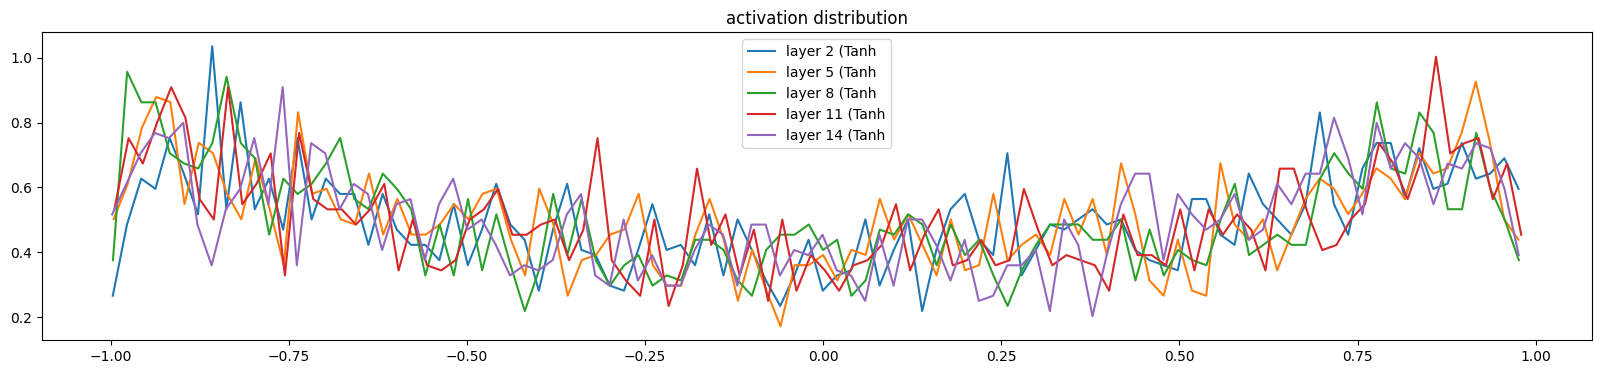

In [127]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 6.369539e-03
layer 5 (      Tanh): mean -0.000000, std 5.287412e-03
layer 8 (      Tanh): mean -0.000000, std 5.121897e-03
layer 11 (      Tanh): mean +0.000000, std 4.722726e-03
layer 14 (      Tanh): mean -0.000000, std 4.491203e-03


Text(0.5, 1.0, 'gradient distribution')

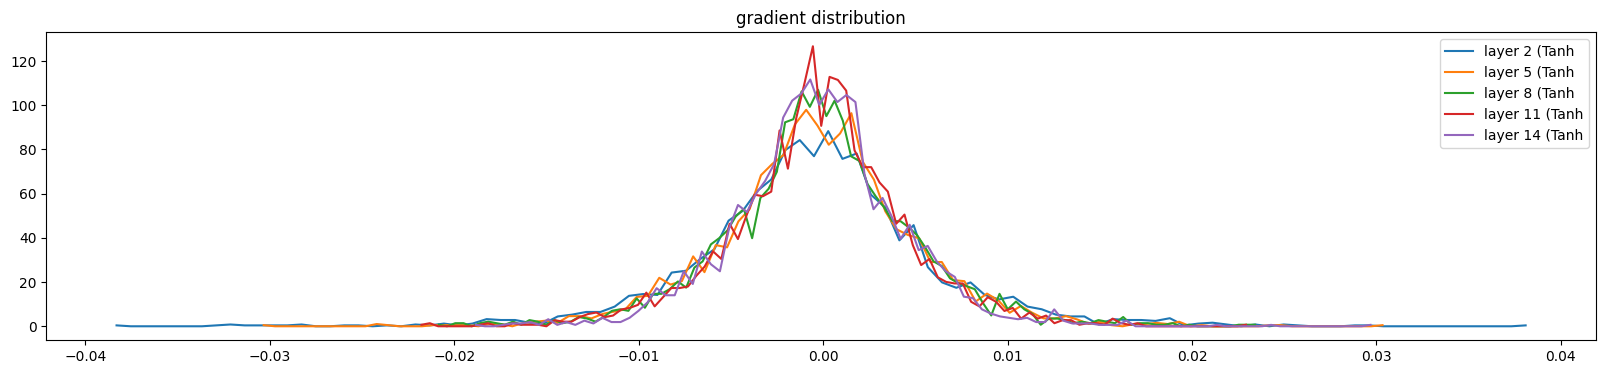

In [128]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')
# stds are basically the same

weight   (27, 10) | mean +0.000000 | std 1.324659e-02 | grad:data ratio 1.316553e-02
weight  (30, 100) | mean -0.000044 | std 4.045796e-03 | grad:data ratio 3.945790e-03
weight (100, 100) | mean -0.000000 | std 2.029399e-03 | grad:data ratio 2.035781e-03
weight (100, 100) | mean -0.000009 | std 1.807335e-03 | grad:data ratio 1.794036e-03
weight (100, 100) | mean -0.000014 | std 1.681489e-03 | grad:data ratio 1.676138e-03
weight (100, 100) | mean -0.000005 | std 1.443977e-03 | grad:data ratio 1.438012e-03
weight  (100, 27) | mean -0.000008 | std 2.586880e-03 | grad:data ratio 2.615686e-03


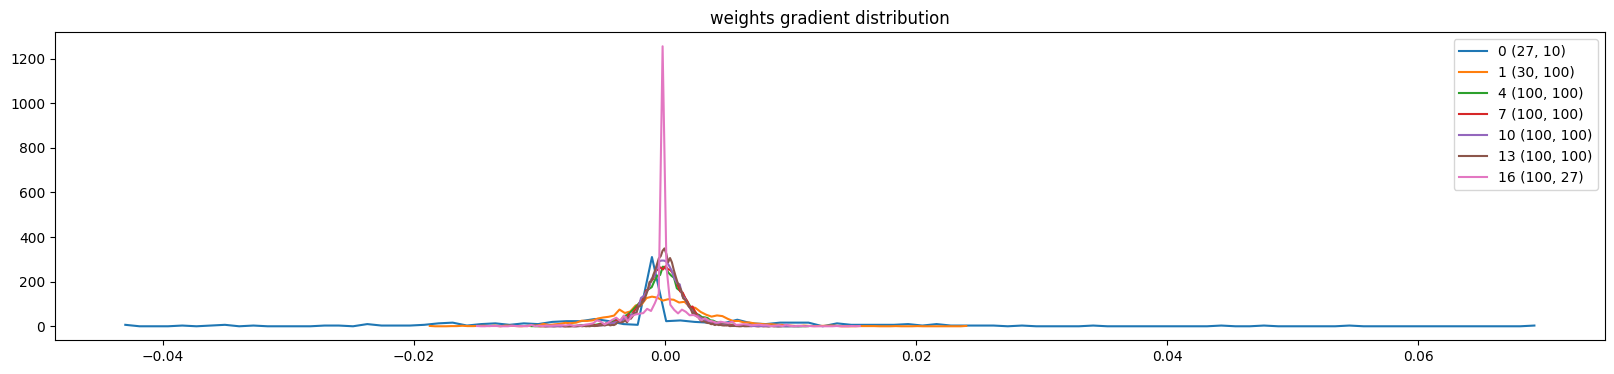

In [129]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

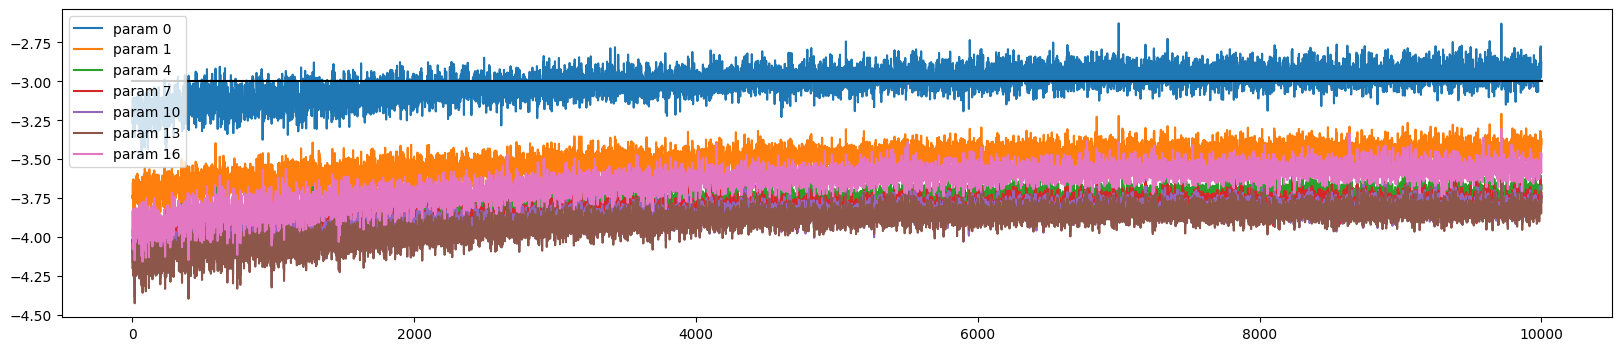

In [130]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);